In [47]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_openai import AzureChatOpenAI
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt

from dotenv import load_dotenv
import os
import uuid

In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
graph_builder = StateGraph(State)

In [4]:
load_dotenv()

True

In [5]:
model = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_CHATGPT_DEPLOYMENT"),
    api_version="2024-12-01-preview",
    temperature=0.7,
    model_name="gpt-4o",
    azure_endpoint=os.getenv("AZURE_OPENAI_SERVICE")
)

In [6]:
def chatbot(input_state: State):
    # Note the output_state is of same Schema as input_state here
    return {"messages": [
        model.invoke(input_state["messages"])
    ]}

In [7]:
# Building the graph using the StateGraph defined
graph_builder.add_node("MyChatbot", chatbot)
graph_builder.add_edge(START, "MyChatbot") # START -> MyChatbot node
graph_builder.add_edge("MyChatbot", END)

# Compiling the graph
graph = graph_builder.compile()

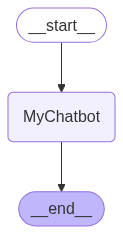

In [8]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error occurred: {e}")

In [9]:
# Running the application through Graph
chat = graph.invoke({"messages": ["Hello there!"]})

chat["messages"][-1].content

'Hello! 😊 How can I assist you today?'

In [10]:
search_tool = TavilySearch(max_results=2, tavily_api_key=os.getenv("TAVILY_API_KEY"))
search_tool.invoke("Who won the last FIFA world cup?")

{'query': 'Who won the last FIFA world cup?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/FIFA_World_Cup',
   'title': 'FIFA World Cup - Wikipedia',
   'content': 'The reigning champions are Argentina, who won their third title at the 2022 World Cup by defeating France. ... Selection process. A map of FIFA World Cup final',
   'score': 0.7368747,
   'raw_content': None},
  {'url': 'https://www.foxsports.com/soccer/fifa-world-cup/history',
   'title': "FIFA Men's World Cup Winners List - FOX Sports",
   'content': "# FIFA World Cup 2026 History Fifa Men's 2026 World Cup | 1990 | West Germany Flag West Germany |  | Argentina Flag Argentina |  | Italy Flag Italy | Host Country | Argentina Flag France Flag France Flag Germany Flag Argentina Flag Germany Flag Italy Flag France Flag Germany Flag Brazil Flag Germany Flag France Flag Brazil Flag Brazil Flag Italy Flag West Germany Flag Argentina Flag Italy Flag Argentina Fla

In [11]:
# Adding another tool
def multiply_tool(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [12]:
# Getting list of tools we have in our arsenal
tools = [search_tool, multiply_tool]

# Binding tools to my LLM
model_with_tools = model.bind_tools(tools)

In [17]:
# Building a new graph
def model_with_tools_function(input_state: State):
    return {"messages": [
        model_with_tools.invoke(input_state["messages"])
    ]}


graph_builder = StateGraph(State)
graph_builder.add_node("LLMWithTools", model_with_tools_function)
graph_builder.add_node("tools", ToolNode(tools)) # we have prebuilt node (no need to create a function and reference here)


graph_builder.add_edge(START, "LLMWithTools")
graph_builder.add_conditional_edges(
    "LLMWithTools",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
graph_builder.add_edge("tools", END)

In [18]:
graph = graph_builder.compile()

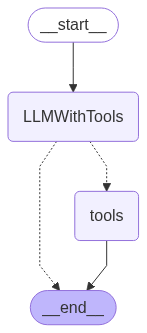

In [19]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error occurred: {e}")

In [20]:
chat = graph.invoke({"messages": ["Who won the last FIFA world cup?"]})
chat

{'messages': [HumanMessage(content='Who won the last FIFA world cup?', additional_kwargs={}, response_metadata={}, id='e1fbfe0d-4ad5-4235-bcf3-71dfd6987c4f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hkPzKPwS2kW4O6Aqm1bI4wup', 'function': {'arguments': '{"query":"last FIFA World Cup winner","time_range":"year","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 1306, 'total_tokens': 1336, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C1zjRucPgU55657GPDAQYA8xXgoqe', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'sa

In [21]:
chat = graph.invoke({"messages": ["What is 10 multiplied by 23"]})
chat

{'messages': [HumanMessage(content='What is 10 multiplied by 23', additional_kwargs={}, response_metadata={}, id='a6deaecd-1376-4325-afd4-db1ccbf8d095'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Vx5MJlGSVnd2lPc0WfdPKLoH', 'function': {'arguments': '{"a":10,"b":23}', 'name': 'multiply_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1306, 'total_tokens': 1325, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C1zlfCIbOuB5chFz6h9mJNNBNJEkM', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'sel

In [ ]:
# See how the tool took inputs from the natural language
chat = graph.invoke({"messages": ["What is 10 multiplied by 23 and then multiplied by -22"]})
chat

{'messages': [HumanMessage(content='What is 10 multiplied by 23 and then multiplied by -22', additional_kwargs={}, response_metadata={}, id='ecd95617-87a5-48e7-b412-0e912de326d4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_i6nAwfEGVRjAKrhGUT5tDvE0', 'function': {'arguments': '{"a": 10, "b": 23}', 'name': 'multiply_tool'}, 'type': 'function'}, {'id': 'call_f0BN1oA0Yo0a2pFmMn628eRQ', 'function': {'arguments': '{"a": 23, "b": -22}', 'name': 'multiply_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 54, 'prompt_tokens': 1312, 'total_tokens': 1366, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C1zn3aAeinSdsUErZD6BpVfdHSaQt', 'service_tier': None, 'prompt_filte

In [ ]:
# We need to change the graph, rerouting the edges for better communication
# Building a new graph to utilize ReAct Architecture
def model_with_tools_function(input_state: State):
    return {"messages": [
        model_with_tools.invoke(input_state["messages"])
    ]}


graph_builder = StateGraph(State)
graph_builder.add_node("LLMWithTools", model_with_tools_function)
graph_builder.add_node("tools", ToolNode(tools)) # we have prebuilt node (no need to create a function and reference here)


graph_builder.add_edge(START, "LLMWithTools")
graph_builder.add_conditional_edges(
    "LLMWithTools",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition # I can even add my own callable with custom logic
)
graph_builder.add_edge("tools", "LLMWithTools")
graph_builder.add_edge("LLMWithTools", END)

In [24]:
graph = graph_builder.compile()

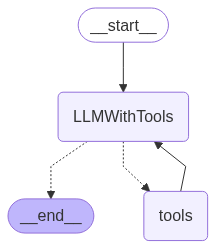

In [25]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error occurred: {e}")

In [26]:
chat = graph.invoke({"messages": ["What is 10 multiplied by 23 and then multiplied by -22"]})
chat

{'messages': [HumanMessage(content='What is 10 multiplied by 23 and then multiplied by -22', additional_kwargs={}, response_metadata={}, id='6a3f3c98-4de9-4b55-b2e7-1f8f3aae9431'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xgKkQSX6DCEC0RdrYxFfqaFN', 'function': {'arguments': '{"a":10,"b":23}', 'name': 'multiply_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 1312, 'total_tokens': 1331, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C200d0XrPJhNj9cDBDAxGzG9leep8', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 

In [ ]:
# Adding short-term memory to the chat
memory = MemorySaver()
thread_id = uuid.uuid4()
graph = graph_builder.compile(checkpointer=memory)
config = {"configurable": {"thread_id": thread_id}}

chat = graph.invoke({"messages": ["Hi, my name is Siddharth"]}, config=config)
chat

{'messages': [HumanMessage(content='Hi, my name is Siddharth', additional_kwargs={}, response_metadata={}, id='c5d43e77-e5ad-4b0d-baa1-af75cd8d4a1c'),
  AIMessage(content='Hello Siddharth! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 1306, 'total_tokens': 1320, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C2073pdB51Y1WA3KI6epmLdZKOWn2', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'viole

In [30]:
chat = graph.invoke({"messages": ["Hi, can you tell me my name?"]}, config=config)
chat

{'messages': [HumanMessage(content='Hi, my name is Siddharth', additional_kwargs={}, response_metadata={}, id='c5d43e77-e5ad-4b0d-baa1-af75cd8d4a1c'),
  AIMessage(content='Hello Siddharth! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 1306, 'total_tokens': 1320, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C2073pdB51Y1WA3KI6epmLdZKOWn2', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'viole

In [34]:
graph.get_state(config)

StateSnapshot(values={'messages': [HumanMessage(content='Hi, my name is Siddharth', additional_kwargs={}, response_metadata={}, id='c5d43e77-e5ad-4b0d-baa1-af75cd8d4a1c'), AIMessage(content='Hello Siddharth! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 1306, 'total_tokens': 1320, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C2073pdB51Y1WA3KI6epmLdZKOWn2', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severit

In [35]:
list(graph.get_state_history(config))

[StateSnapshot(values={'messages': [HumanMessage(content='Hi, my name is Siddharth', additional_kwargs={}, response_metadata={}, id='c5d43e77-e5ad-4b0d-baa1-af75cd8d4a1c'), AIMessage(content='Hello Siddharth! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 1306, 'total_tokens': 1320, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C2073pdB51Y1WA3KI6epmLdZKOWn2', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severi

In [36]:
memory.delete_thread(thread_id=thread_id)

In [ ]:
graph.get_state(config)


StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': 'user_1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

In [41]:
# Streaming the output 
thread_id = uuid.uuid4()
print(thread_id)
config = {"configurable": {"thread_id": thread_id}}

for chunk in graph.stream({"messages": ["Hi, my name is Siddharth"]}, config=config, stream_mode="updates"):
    print(chunk)

acac366c-0c72-43f6-ad42-fd595f2248ff
{'LLMWithTools': {'messages': [AIMessage(content='Hello, Siddharth! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 1306, 'total_tokens': 1321, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1152}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C20VgA2psa6BIT9fPYkXrINwClusG', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs

In [42]:
thread_id = uuid.uuid4()
print(thread_id)
config = {"configurable": {"thread_id": thread_id}}

for chunk in graph.stream({"messages": ["Hi, my name is Siddharth"]}, config=config, stream_mode="values"):
    print(chunk)

d0835bf8-c2f6-4f1f-9e56-3cfe18990396
{'messages': [HumanMessage(content='Hi, my name is Siddharth', additional_kwargs={}, response_metadata={}, id='39c690a2-f762-4ab8-8d77-bbbd5bdf62c6')]}
{'messages': [HumanMessage(content='Hi, my name is Siddharth', additional_kwargs={}, response_metadata={}, id='39c690a2-f762-4ab8-8d77-bbbd5bdf62c6'), AIMessage(content='Hello Siddharth! How can I assist you today? 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 1306, 'total_tokens': 1321, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C20VqVn2i7x7As3tfIJNVg7RV7boo', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False,

In [43]:
# If stream_mode="updates", then only last message gets streamed back, 
# in "values", each message which was appended in our history gets streamed
# one message at a time

In [45]:
# Async streaming
thread_id = uuid.uuid4()
print(thread_id)
config = {"configurable": {"thread_id": thread_id}}

async for chunk in graph.astream_events({"messages": ["Hi, my name is Siddharth"]}, config=config):
    print(chunk)

28edbf75-d14e-46bc-8654-9dda7d6afede
{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi, my name is Siddharth']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '3ef21658-3337-4a47-9683-00171a639b51', 'metadata': {}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi, my name is Siddharth', additional_kwargs={}, response_metadata={}, id='8b4bc305-3741-4049-8bce-8c3983a03441')]}}, 'name': 'LLMWithTools', 'tags': ['graph:step:1'], 'run_id': 'c8020ca4-d061-465d-b57a-3103eb8cb769', 'metadata': {'langgraph_step': 1, 'langgraph_node': 'LLMWithTools', 'langgraph_triggers': ('branch:to:LLMWithTools',), 'langgraph_path': ('__pregel_pull', 'LLMWithTools'), 'langgraph_checkpoint_ns': 'LLMWithTools:6c526745-0a9b-49c7-a3f2-1b313617a491'}, 'parent_ids': ['3ef21658-3337-4a47-9683-00171a639b51']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi, my name is Siddharth', additional_kwargs={}, response_

In [48]:
# Human-in-the-loop - Human feedback in our graph

graph_builder = StateGraph(State)

@tool
def human_assistance_tool(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [search_tool, multiply_tool, human_assistance_tool]
llm_with_tools = model.bind_tools(tools)

def model_with_tools_function(input_state: State):
    return {"messages": [
        llm_with_tools.invoke(input_state["messages"])
    ]}


graph_builder.add_node("LLMWithTools", model_with_tools_function)
graph_builder.add_node("tools", ToolNode(tools)) # we have prebuilt node (no need to create a function and reference here)


graph_builder.add_edge(START, "LLMWithTools")
graph_builder.add_conditional_edges(
    "LLMWithTools",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition # I can even add my own callable with custom logic
)
graph_builder.add_edge("tools", "LLMWithTools")
graph_builder.add_edge("LLMWithTools", END)

In [50]:
memory = MemorySaver() # creating a new memory
thread_id = uuid.uuid4()
graph = graph_builder.compile(checkpointer=memory)
config = {"configurable": {"thread_id": thread_id}}

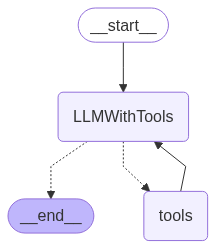

In [51]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error occurred: {e}")

In [52]:
chat = graph.invoke({"messages": [
    "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
]}, config=config)
chat

{'messages': [HumanMessage(content='I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='422be119-86bd-47e1-8a5a-b67daf8de86f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lXzsiyoAIoJv2YxWC5BKZHb5', 'function': {'arguments': '{"query":"I need expert guidance and assistance for building an AI agent. Can you help?"}', 'name': 'human_assistance_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 1340, 'total_tokens': 1373, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-C20mTgEbT1u4FNrx8kEJPZtR7ZEuv', 'service_tier': None, 'prompt_filter_results

In [53]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance_tool (call_lXzsiyoAIoJv2YxWC5BKZHb5)
 Call ID: call_lXzsiyoAIoJv2YxWC5BKZHb5
  Args:
    query: I need expert guidance and assistance for building an AI agent. Can you help?
================================= Tool Message =================================
Name: human_assistance_tool

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts recommend using LangGraph for building your AI agent, as it is reliable and extensible compared to simple autonomous agents. Let me know if you need more details or further assistance!
